# Yearly drug deaths by type, 2010-2017

This notebook loads the data from in `data/mcd/national` and `data/vssr/` to produce a time-series plot showing up-to-date national figures for overdoses due to opioids, heroin, cocaine and prescription opioid overdoses. Because the CDC Wonder database only contains data up to 2016, these figures are combined with provisional figures provided by the [Vital Statistics Rapid Release](https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm). The provisional data allows us to plot 2010 through September 2017.

Note that provisional counts tend to undercount deaths as compared to the finalized numbers found in the CDC's Wonder database. According to the [CDC's documentation](https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm):

```
Provisional counts of drug overdose deaths may underestimate the final counts primarily due to the omission of deaths pending investigation of the cause and manner of death. The degree of underestimation is likely greater for more recent months when the numbers of deaths pending investigation are highest. This underestimation may affect the ability to evaluate trends during the most recent period. Methods to adjust provisional data are under development and will be applied in future releases.
```

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import os
import matplotlib.font_manager as fm
from matplotlib import rcParams

## Set some matplot properties for aesthetics

In [2]:
# Space between headline and axis
rcParams['axes.titlepad'] = 20 

In [3]:
# Check for fonts if available

# check for avenir
if os.path.isfile("../fonts/AvenirNext-Regular.ttf"):
    tickfont = fm.FontProperties(
        fname="../fonts/AvenirNext-Regular.ttf", 
        size = 24
    )
    
    labelfont = fm.FontProperties(
        fname="../fonts/AvenirNext-Regular.ttf", 
        size = 22
    )
else:
    tickfont = fm.FontProperties(
        family="Arial", 
        size = 24
    )
    
    labelfont = fm.FontProperties(
        family="Arial", 
        size = 22
    )

# check for proxima nova extra bold
if os.path.isfile("../fonts/ProximaNova-Xbold-webfont.woff"):
    titlefont = fm.FontProperties(
        fname = "../fonts/ProximaNova-Xbold-webfont.woff",
        size = 36
    )
else:
    titlefont = fm.FontProperties(
        family = "Arial",
        size = 36
    )

## Load monthly final counts

In [4]:
def read_mcd(drugname):
    df = (
        pd
        .read_csv(
            "../data/mcd/national/{}_monthly_10_16_national.txt".format(drugname),
            delimiter = "\t",
            dtype = {
                "Year": str,
            }
        )
        .loc[lambda x: x['Notes'].isnull()]
        .drop(columns = [
            "Crude Rate", 
            "Year Code",
            "Notes",
            "Population",
            "Year",
            "Month"
        ])
        .assign(
            Deaths = lambda x: x["Deaths"].astype(int)
        )
        .rename(columns = {
            "Deaths": drugname
        })
    )
    
    return df

In [5]:
coc = read_mcd("cocaine")

heroin = read_mcd("heroin")

fentanyl = read_mcd("fentanyl")

rx = read_mcd("rxopioids")

monthly_final = (
    reduce(
        lambda x, y: x.merge(y, on = "Month Code"),
        [coc, heroin, fentanyl, rx]
    )
    .set_index("Month Code")
    .rename(
        columns={
            "cocaine": "Cocaine",
            "heroin": "Heroin",
            "fentanyl": "Fentanyl",
            "rxopioids": "Rx Opioids"
        }
    )
)

monthly_final.tail()

,Cocaine,Heroin,Fentanyl,Rx Opioids
Month Code,,,,
2016/08,936,1316,1576,1224
2016/09,957,1283,1713,1150
2016/10,972,1241,1885,1220
2016/11,988,1325,1987,1200
2016/12,1007,1466,2160,1260


In [6]:
monthly_final.head()

,Cocaine,Heroin,Fentanyl,Rx Opioids
Month Code,,,,
2010/01,358,199,282,947
2010/02,336,198,262,950
2010/03,388,250,266,972
2010/04,343,266,267,917
2010/05,356,277,252,919


In [7]:
rolling_12mo_final = (
    monthly_final
    .rolling(12).sum()
    .dropna()
    .astype(int)
)

rolling_12mo_final.head()

,Cocaine,Heroin,Fentanyl,Rx Opioids
Month Code,,,,
2010/12,4183,3036,3007,10943
2011/01,4173,3160,2949,11020
2011/02,4262,3293,2908,11044
2011/03,4241,3409,2887,11108
2011/04,4326,3520,2847,11234


## Load provisional rolling 12-month counts

In [8]:
(    pd
    .read_csv(
        "../data/vssr/VSRR_Provisional_Drug_Overdose_Death_Counts.csv",
        thousands = ","
    )
)['Indicator'].unique()

array(['Number of Deaths', 'Number of Drug Overdose Deaths',
       'Cocaine (T40.5)', 'Heroin (T40.1)', 'Methadone (T40.3)',
       'Natural & semi-synthetic opioids (T40.2)',
       'Opioids (T40.0-T40.4,T40.6)', 'Percent with drugs specified',
       'Psychostimulants with abuse potential (T43.6)',
       'Synthetic opioids, excl. methadone (T40.4)'], dtype=object)

In [9]:
rolling_12mo_provisional = (
    pd
    .read_csv(
        "../data/vssr/VSRR_Provisional_Drug_Overdose_Death_Counts.csv",
        thousands = ","
    )
    .loc[lambda x: (
        x["Indicator"].isin([
            "Cocaine (T40.5)",
            "Heroin (T40.1)",
            "Natural & semi-synthetic opioids (T40.2)",
            "Synthetic opioids, excl. methadone (T40.4)"
        ]) &
        # Use only the national data
        (x["State Name"] == "United States") & 
        (x["Year"] == 2017)
    )]
    .assign(**{
        "Month Code": lambda x: (
            pd.to_datetime(x["Month"] + " " + x["Year"].astype(str))
            .dt.strftime("%Y/%m")
        )
    })
    .set_index([
        "Month Code",
        "Indicator",
    ])
    ["Data Value"]
    .astype(int)
    .unstack()
    .rename(columns = {
        "Cocaine (T40.5)": "Cocaine",
        "Heroin (T40.1)": "Heroin",
        "Natural & semi-synthetic opioids (T40.2)": "Rx Opioids",
        "Synthetic opioids, excl. methadone (T40.4)": "Fentanyl"
    })
)

rolling_12mo_provisional

Indicator,Cocaine,Heroin,Rx Opioids,Fentanyl
Month Code,,,,
2017/01,10912,15801,14697,20831
2017/02,11218,15850,14713,21655
2017/03,11540,15843,14700,22395
2017/04,11901,15780,14716,23005
2017/05,12211,15824,14806,23678
2017/06,12598,15785,14717,24455
2017/07,12698,15589,14637,24957
2017/08,12910,15457,14440,25578
2017/09,12995,15301,14309,26127


## Combine the two datasets, and calculate the rolling 12-month totals

In [10]:
rolling_12mo = (
    pd.concat([
        rolling_12mo_final,
        rolling_12mo_provisional
    ])
    .reset_index()
    .assign(
        chart_date = lambda x: (
            pd.to_datetime(x["Month Code"].str.replace("/", "-") + "-01") +
            pd.DateOffset(months = 1) # So that the lines go through the end of each month
        )
    )
    .set_index("chart_date")
    .drop(columns = "Month Code")
)[[ "Fentanyl", "Cocaine", "Heroin", "Rx Opioids" ]]

rolling_12mo.tail(10)

,Fentanyl,Cocaine,Heroin,Rx Opioids
chart_date,,,,
2017-01-01,19413,10375,15469,14487
2017-02-01,20831,10912,15801,14697
2017-03-01,21655,11218,15850,14713
2017-04-01,22395,11540,15843,14700
2017-05-01,23005,11901,15780,14716
2017-06-01,23678,12211,15824,14806
2017-07-01,24455,12598,15785,14717
2017-08-01,24957,12698,15589,14637
2017-09-01,25578,12910,15457,14440


## Plot the rolling 12-month totals

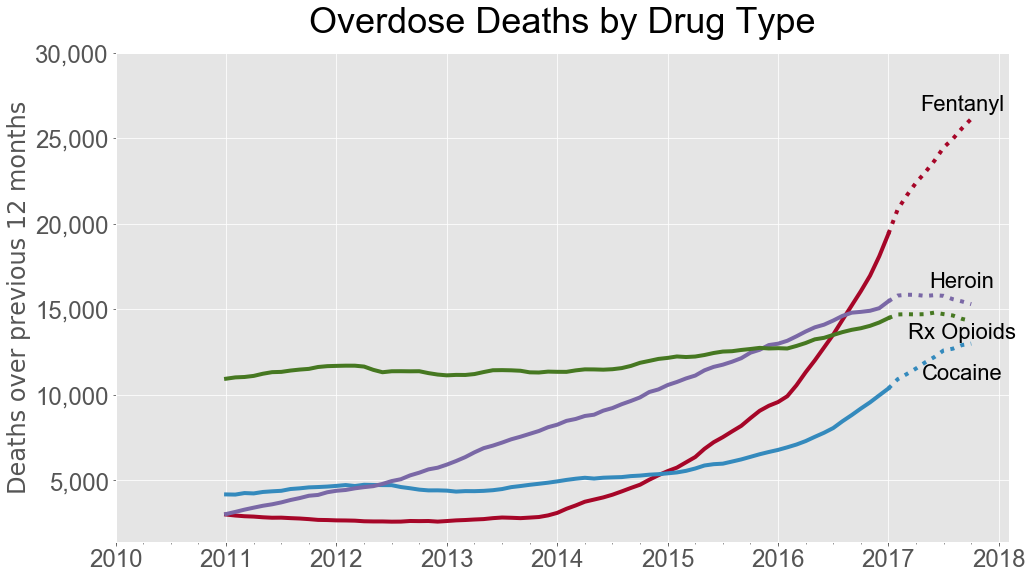

In [11]:
plt.style.use("ggplot")

ggplot_colors = [
    "#A60628",
    "#348ABD",
    "#7A68A6",
    "#467821", 
]

fig, ax = plt.subplots(figsize = (16,9))

(
    rolling_12mo
    .loc[:"2017-01-01"]
    .plot(
        ax = ax,
        lw = 4,
        legend = False,
        color = ggplot_colors[:4]
    )
)

(
    rolling_12mo
    .loc["2017-01-01":]
    .plot(
        ax = ax,
        lw = 4,
        color = ggplot_colors[:4],
        legend = False,
        linestyle = "dotted",
    )
)

text_shift = {
    "Heroin": 1000,
    "Cocaine": -2100,
    "Rx Opioids": -1000
}

for drug, count in rolling_12mo.iloc[-1].iteritems():
    ax.text(
        rolling_12mo.index[-2], 
        count + text_shift.get(drug, 500), 
        drug, 
        horizontalalignment='center',
        fontproperties=labelfont)

# set font of tick labels
for label in ax.get_xticklabels():
    label.set_fontproperties(tickfont)

for label in ax.get_yticklabels():
    label.set_fontproperties(tickfont)

ax.set_ylim(None, 30000)
ax.set_yticklabels([ "{:,.0f}".format(y) for y in ax.get_yticks() ])

# make sure xtick starts at 2010
ax.set_xticks([480, 492, 504, 516, 528, 540, 552, 564, 576])

ax.set_title("Overdose Deaths by Drug Type", 
             fontsize = 36,
            fontproperties = titlefont)

ax.set_ylabel("Deaths over previous 12 months", fontsize = 24)
ax.set_xlabel("")

pass

---

---

---